In [108]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from util import *
from pysmileUtil import *
import matplotlib.pyplot as plt
from pyAgrumUtil import *
#import networkx as nx
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import numpy as np

import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
#information gain
#from sklearn.feature_selection import mutual_info_classif

# variable contribution
from tsquared import HotellingT2, MYTDecomposition
from xgboost import XGBRegressor


# Bayesian
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, BicScore, TreeSearch, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyreadr
train_normal_path = 'TEP2017R/TEP_FaultFree_Training.RData'
train_faulty_path =  'TEP2017R/TEP_Faulty_Training.RData'
test_normal_path = 'TEP2017R/TEP_FaultFree_Testing.RData'
test_faulty_path = 'TEP2017R/TEP_Faulty_Testing.RData'
 
train_normal = pyreadr.read_r(train_normal_path)['fault_free_training']
train_faulty = pyreadr.read_r(train_faulty_path)['faulty_training']
#test_normal = pyreadr.read_r(test_normal_path)['fault_free_testing']
#test_faulty = pyreadr.read_r(test_faulty_path)['faulty_testing']

# only keep continuous variables, xmeas_1 - xmeas_22
df_train_normal = train_normal[train_normal.simulationRun==1].iloc[:,3:25]
df_train_faulty = train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==12)].iloc[:,3:25]
#df_test_normal = test_normal[test_normal.simulationRun==1].iloc[:,3:25]

kFeatures = len(df_train_normal.columns)
features = list(df_train_normal.columns)

ss = StandardScaler().set_output(transform="pandas")
ss_df_train_normal = ss.fit_transform(df_train_normal)

# TEP truths
faultToRoot = {1:'xmeas_4', 4:'xmeas_9', 5:'xmeas_22', 6:'xmeas_1', 11:'xmeas_21', 12:'xmeas_11', 14:'xmeas_9', 15:'xmeas_11'}
faultToVariables = {1:['xmeas_1', 'xmeas_4', 'xmeas_18', 'xmeas_21', 'xmeas_25', 'xmeas_26'],
                    14:['xmeas_9', 'xmeas_11', 'xmeas_21', 'xmeas_32']}
reactor = ['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
           'xmeas_20','xmeas_21']
seperator = ['xmeas_7', 'xmeas_20', 'xmeas_21', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_22']
stripper = ['xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_22', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 
           'xmeas_19', 'xmeas_4', 'xmeas_5']

In [113]:
feature_importance = featureDCIG(ss_df_train_normal, ss.transform(df_train_faulty))
evidence = features[np.argmax(feature_importance)]
print(evidence)

xmeas_20


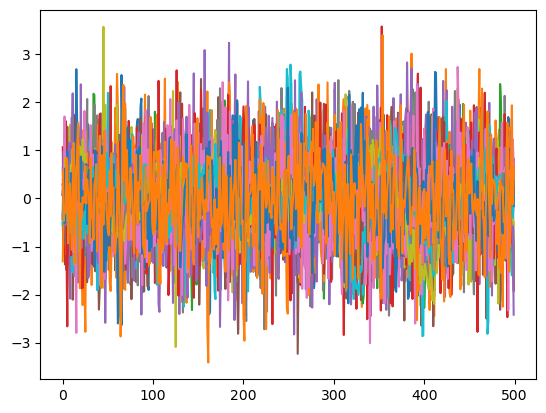

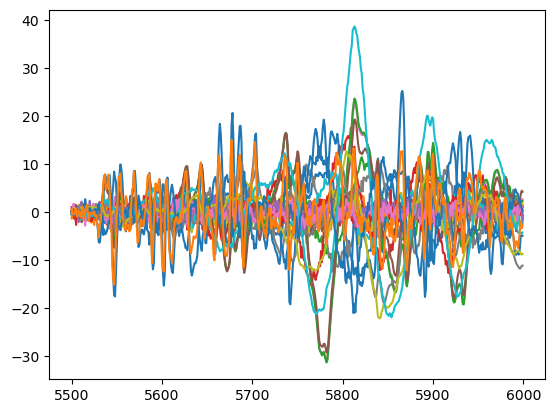

In [3]:
#KPCA
kpca = KernelPCA(n_components=4, kernel='rbf', fit_inverse_transform=True)
x_faulty = ss.transform(df_train_faulty,copy=None)
x_kpca = kpca.fit(ss_df_train_normal)
x_fault_free_reconstructed = kpca.inverse_transform(kpca.transform(ss_df_train_normal))
x_faulty_reconstructed = kpca.inverse_transform(kpca.transform(x_faulty))

normal_residuals = x_fault_free_reconstructed - ss_df_train_normal
plt.plot(normal_residuals)
plt.show()

faulty_residuals = x_faulty_reconstructed - x_faulty
plt.plot(faulty_residuals)
plt.show()

In [119]:
df_train_normal_residuals = pd.DataFrame(data=normal_residuals, columns=features)
df_train_faulty_residuals = pd.DataFrame(data=faulty_residuals, columns=features)

df_alarm = alarm_df(df_train_normal_residuals, df_train_faulty_residuals)
TETable = transferEntropyTable(df_alarm, 4, 0.05)
edges = getTableEdges(TETable, features)
nodes = getNodesFromEdges(edges)
print(len(nodes))
print(len(edges))
'''
net = getBayesianNet(df_alarm)
for node in net.get_all_nodes():
    print_node_info(net, node)'''

11
9


'\nnet = getBayesianNet(df_alarm)\nfor node in net.get_all_nodes():\n    print_node_info(net, node)'

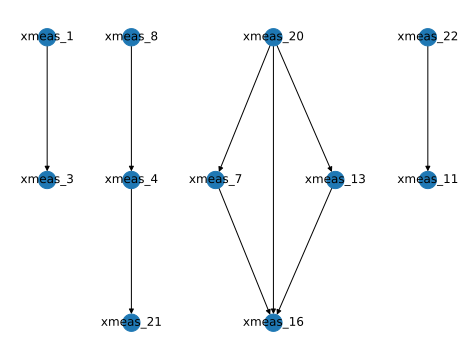

In [120]:
drawBN(edges)

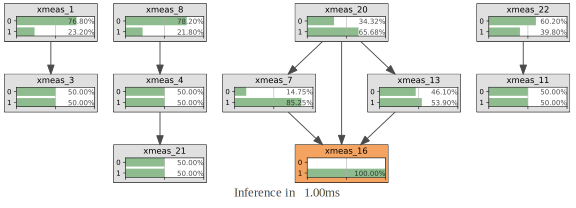

In [122]:
bn = getPyAgrumBayesNet(df_alarm, nodes, edges)
gnb.showInference(bn,evs={'xmeas_16':1})

7
20


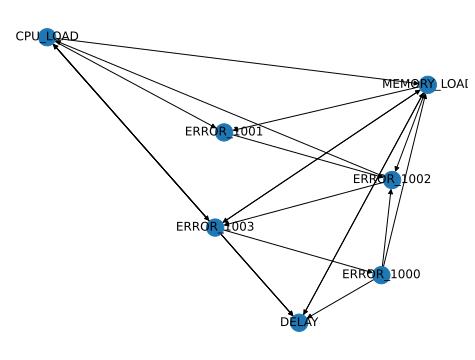

InvalidDirectedCycle: [pyAgrum] Directed cycle detected: Add a directed cycle in a dag !

In [134]:
data_train = pd.read_csv('ITOps_root_cause_analysis.csv', header=None).values
train_y = data_train[:, -1]
data_train = data_train[:,1:-1]
df_train_normal = pd.DataFrame(data=data_train[1:, :], columns=data_train[0,:])
features = list(df_train_normal.columns)
TETable = transferEntropyTable(df_train_normal, 4, 0.05)
edges = getTableEdges(TETable, features)
nodes = getNodesFromEdges(edges)
print(len(nodes))
print(len(edges))
drawBN(edges)
bn = getPyAgrumBayesNet(df_train_normal, nodes, edges)
gnb.showInference(bn,evs={'ERROR_1001':1, 'ERROR_1003':1})

In [1]:
data_train = pd.read_csv('FCC/NOC_varyingFeedFlow_outputs.csv', header=None).values
data_train = data_train[:,1:] # first column gives sampling time
df_train_normal = pd.DataFrame(data=data_train[:, :14])
df_train_normal = df_train_normal.iloc[:, df_train_normal.columns[df_train_normal.nunique() > 1]]
data_test = pd.read_csv('FCC/condEff_decrease_outputs.csv', header=None).values
data_test = data_test[:,1:]
df_train_faulty = pd.DataFrame(data=data_test[:, :14])
df_train_faulty = df_train_faulty.iloc[:, df_train_faulty.columns[df_train_faulty.nunique() > 1]]
kFeatures = len(df_train_normal.columns)
feature_list = list(df_train_normal.columns)

NameError: name 'pd' is not defined

In [220]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    gamma = 1 / X.shape[1]
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = np.exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    print(eigvals)
    print(eigvecs)
    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, i]
                            for i in range(n_components)))

    return X_pc

(500,)
(500, 500)


C:\Users\paulo\AppData\Local\Temp\ipykernel_12128\3892154058.py:42: RuntimeWarning: divide by zero encountered in power
  t2 = (K_centered.T).dot(eigvecs).dot(np.diag(eigvals) ** -2).dot(eigvecs.T).dot(K_centered)


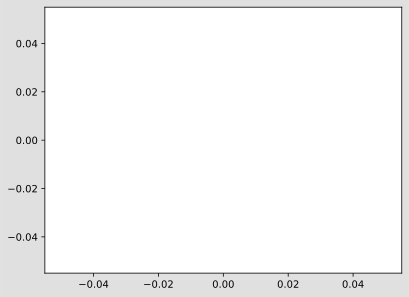

In [78]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train_normal)

# Step 3: Compute the Kernel Matrix (using RBF kernel as an example)
gamma = 1.0 / X_scaled.shape[1]
K = rbf_kernel(X_scaled, gamma=gamma)

# Step 4: Center the Kernel Matrix
N = K.shape[0]
one_n = np.ones((N, N)) / N
K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

# Step 5: Perform Eigen Decomposition
eigvals, eigvecs = np.linalg.eigh(K_centered)

# Sort eigenvalues and eigenvectors
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Step 6: Project Data onto Principal Components
n_components = 2  # Number of principal components to keep
alphas = eigvecs[:, :n_components]
lambdas = eigvals[:n_components]

print(eigvals.shape)
print(eigvecs.shape)

# Step 7: Reconstruct the Data
X_reconstructed = alphas.dot(alphas.T).dot(K_centered)

# Step 8: Calculate the Residual
#residuals = K_centered - X_reconstructed
#residuals = X_scaled - X_reconstructed

t2 = (K_centered.T).dot(eigvecs).dot(np.diag(eigvals) ** -2).dot(eigvecs.T).dot(K_centered)

plt.plot(t2)
plt.show()

In [66]:
scaler = StandardScaler()
scaler.fit(df_train_normal)

data_train_normal = scaler.transform(df_train_normal)
pca = KernelPCA(kernel="rbf")
score_train = pca.fit_transform(data_train_normal)

V_matrix = pca.eigenvectors_
lambda_k = pca.eigenvalues_

print(lambda_k)
print(V_matrix)
explained_variance = np.var(score_train, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cum_explained_variance = np.cumsum(explained_variance_ratio)
n_comp = np.argmax(cum_explained_variance >= 0.95) + 1


print('Number of PCs cumulatively explaining atleast 95% variance: ', n_comp)
score_train_reduced = score_train[:,0:n_comp]


# reconstruct original data
#https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
# V is eigenvectors, L is diagnoal matrix with eigen values
P_matrix = V_matrix[:,:n_comp]
lambda_k = lambda_k[:n_comp]
# (500, 22) = (500, 16) * (16,22)
# (500, 22) = (500, 332) * (332, 500)
data_train_normal_reconstruct = np.dot(score_train_reduced, P_matrix.T)

print("eigenvector", V_matrix.shape)
print("P_matrix",P_matrix.T.shape)
print("eigenvalue", lambda_k.shape)
print("score_test", score_train.shape)
print("score_test_reduced", score_train_reduced.shape)
print("data train normal", data_train_normal.shape)
print("data train normal reconstruct", data_train_normal_reconstruct.shape)
print(lambda_k)

error_train = data_train_normal - data_train_normal_reconstruct
print(error_train)
# calculate T2 for training data
k = n_comp

lambda_k = pca.eigenvalues_

T2_train = np.zeros((N,))

for i in range(N):
    T2_train[i] = np.dot(np.dot(score_train_reduced[i,:],lambda_k),score_train_reduced[i,:].T)
    
T2_CL = np.percentile(T2_train, 99)

#% calculate Q for training data
error_train = data_train_normal - data_train_normal_reconstruct
Q_train = np.sum(error_train*error_train, axis = 1)
Q_CL = np.percentile(Q_train, 99)

#methdo to draw dashed line 
#plt.plot([1,len(Q_train)],[Q_CL,Q_CL], linestyle='--',color='red', linewidth=2)

[26.65691458 16.97674451 13.19639985 10.8537001   9.9565868   9.07680407
  8.71507076  8.25326036  7.80894171  7.72465919  7.3249032   6.84797896
  6.66989951  6.14269964  6.00516489  5.65897944  5.12888005  4.65507257
  4.21719428  3.7656247   3.48942329  3.11619558  3.02041139  2.80473251
  2.72706909  2.66606931  2.49312782  2.39225912  2.31742884  2.29664587
  2.21604927  2.11683091  2.08226343  2.03794016  1.98000289  1.95603969
  1.90393026  1.87302475  1.81241311  1.80896356  1.77260267  1.73425285
  1.68490946  1.6219285   1.58341458  1.56347612  1.52213834  1.51074135
  1.49000583  1.47624914  1.44992547  1.4309328   1.41337731  1.39129041
  1.35389461  1.33161288  1.30678268  1.29909883  1.27471425  1.25426501
  1.24694996  1.21818354  1.21192897  1.19419484  1.18824449  1.17775994
  1.16291251  1.14224856  1.13170257  1.11974083  1.11366812  1.08848755
  1.07239567  1.06658722  1.0450142   1.04257095  1.03062344  1.02491415
  1.01860317  0.9917695   0.98275746  0.97450112  0

ValueError: operands could not be broadcast together with shapes (500,22) (500,500) 

In [144]:
df_train_normal = train_normal[train_normal.simulationRun==1].iloc[:,3:25]
df_train_faulty = train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==12)].iloc[:,3:25]
scaler = StandardScaler()
scaler.fit(df_train_normal)

data_train_normal = scaler.transform(df_train_normal)
pca = PCA()
score_train = pca.fit_transform(data_train_normal)

n_comp = getPCANumComponents(pca)
print('Number of PCs cumulatively explaining atleast 95% variance: ', n_comp)
score_train_reduced = score_train[:,0:n_comp]

# reconstruct original data
#https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
# V is eigenvectors, L is diagnoal matrix with eigen values
V_matrix = pca.components_.T
P_matrix = V_matrix[:,0:n_comp] 

data_train_normal_reconstruct = np.dot(score_train_reduced, P_matrix.T)

# calculate T2 for training data
k = n_comp

lambda_k = np.diag(pca.explained_variance_[0:k]) # eigenvalue = explained variance
lambda_k_inv = np.linalg.inv(lambda_k)
print("eigenvector", V_matrix.shape)
print("P_matrix",P_matrix.T.shape)
print("eigenvalue", lambda_k_inv.shape)
print("score_test", score_train.shape)
print("score_test_reduced", score_train_reduced.shape)
print("data train normal", data_train_normal.shape)
print("data train normal reconstruct", data_train_normal_reconstruct.shape)
#print(V_matrix)
#print(P_matrix)
#print(lambda_k)

T2_train = np.zeros((N,))

for i in range(N):
    T2_train[i] = np.dot(np.dot(score_train_reduced[i,:],lambda_k_inv),score_train_reduced[i,:].T)
    
T2_CL = np.percentile(T2_train, 99)

#% calculate Q for training data
error_train = data_train_normal - data_train_normal_reconstruct
Q_train = np.sum(error_train*error_train, axis = 1)
Q_CL = np.percentile(Q_train, 99)

print(error_train.shape)
#methdo to draw dashed line 
#plt.plot([1,len(Q_train)],[Q_CL,Q_CL], linestyle='--',color='red', linewidth=2)

Number of PCs cumulatively explaining atleast 95% variance:  16
eigenvector (22, 22)
P_matrix (16, 22)
eigenvalue (16, 16)
score_test (500, 22)
score_test_reduced (500, 16)
data train normal (500, 22)
data train normal reconstruct (500, 22)
(500, 22)


In [165]:
feature_importance = QContributions(ss.transform(df_train_normal), ss.transform(df_train_faulty))
evidence = features[np.argmax(feature_importance)]

[ 186.5193926   554.46761186   49.77352896   96.33615449   71.3501236
   79.80979169  343.02484557  140.91205527   87.07020708  121.18993254
 1881.07927983   15.24835169  306.1892602     7.35172596   33.43347049
 1037.78401723  113.30300223 1309.53309613 1374.61187935 3788.0692461
  738.80783525 1650.33446911]
xmeas_20


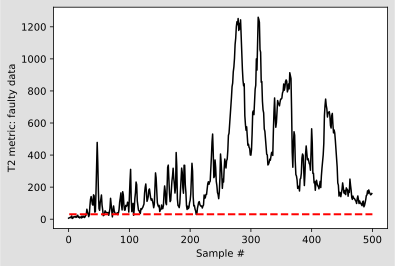

score_test (500, 22)
score_test_reduced (500, 16)
P_matrix (16, 22)


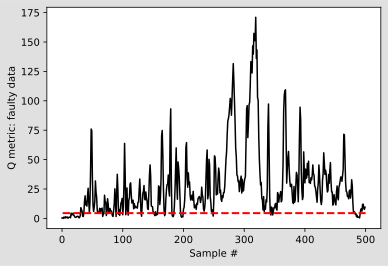

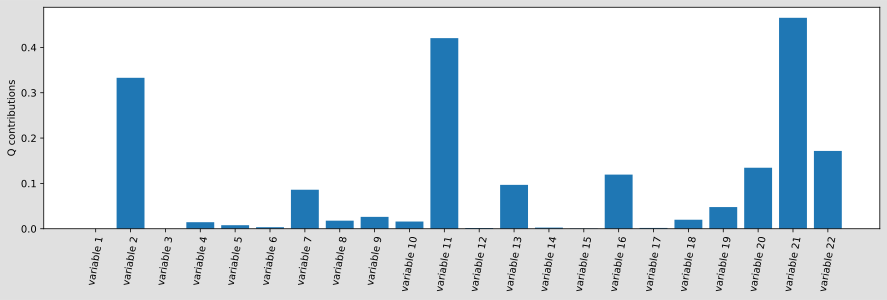

In [140]:
#df_train_faulty1 = train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==6)].iloc[:,3:25]
data_test_normal = scaler.transform(df_train_faulty) # using scaling parameters from training data

# compute scores and reconstruct
score_test = pca.transform(data_test_normal)
score_test_reduced = score_test[:,0:k]

data_test_normal_reconstruct = np.dot(score_test_reduced, P_matrix.T)

#calculate T2_test
T2_test = np.zeros((data_test_normal.shape[0],))

for i in range(data_test_normal.shape[0]): # eigenvalues from training data are used
    T2_test[i] = np.dot(np.dot(score_test_reduced[i,:],lambda_k_inv),score_test_reduced[i,:].T)

# plot Q_test and Q_train with CL
plt.figure(figsize=[6,4])
plt.plot(T2_test, color='black')
plt.plot([1,len(T2_test)],[T2_CL,T2_CL], linestyle='--',color='red', linewidth=2)
plt.xlabel('Sample #')
plt.ylabel('T2 metric: faulty data')
plt.show()

#calculate Q_test
error_test = data_test_normal_reconstruct - data_test_normal
print("score_test", score_test.shape)
print("score_test_reduced", score_test_reduced.shape)
print("P_matrix",P_matrix.T.shape)
Q_test = np.sum(error_test*error_test, axis = 1)

# plot Q_test and Q_train with CL
plt.figure(figsize=[6,4])
plt.plot(Q_test, color='black')
plt.plot([1,len(Q_test)],[Q_CL,Q_CL], linestyle='--',color='red', linewidth=2)
plt.xlabel('Sample #')
plt.ylabel('Q metric: faulty data')
plt.show()

#%% Q contribution
sample = 250

error_test_sample = error_test[sample-1,]
Q_contri = error_test_sample*error_test_sample # vector of contributions

plt.figure(figsize=[15,4])
plt.bar(['variable ' + str((i+1)) for i in range(len(Q_contri))], Q_contri)
plt.xticks(rotation = 80)
plt.ylabel('Q contributions')
plt.show()

In [239]:
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
hotelling_t2s = np.array([xi.dot(loadings)
                            .dot(np.diag(eigenvalues ** -1))
                            .dot(loadings.T)
                            .dot(xi.T)
                          for xi in x])
t_contribution = np.array([xi.dot(loadings).dot(np.diag(np.sqrt(1/eigenvalues))).dot(loadings.T) for xi in x])
print(t_contribution)

AttributeError: 'KernelPCA' object has no attribute 'components_'

In [80]:
def displayComponentStatistics(data, pca_model, kComponents):
    name = list(df_train_normal.columns)
    score = abs(pca.components_)
    print(sorted(zip(score[0], name), reverse=True)[:kComponents])
    print(sorted(zip(score[1], name), reverse=True)[:kComponents])
    print(np.sum(pca.explained_variance_ratio_[:kComponents]))

def hotelling_t_squared(data, pca_model):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Calculate centroid in principal component space
    centroid = np.mean(transformed_data, axis=0)
    
    # Calculate Mahalanobis distance (T^2 score) for each sample
    t_squared_scores = np.sum((transformed_data - centroid)**2 / pca_model.explained_variance_, axis=1)
    return t_squared_scores

#doesn't work
def calculate_cdc_score(data, pca_model, faulty_indices):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Extract relevant components and covariance matrix
    principal_components = pca_model.components_
    covariance_matrix = np.cov(transformed_data.T)
    
    # Calculate CDC scores for each faulty instance and each variable
    cdc_scores = []
    for idx in faulty_indices:
        t_squared_instance = transformed_data[idx]
        cdc_score_instance = np.zeros(len(principal_components))
        for i in range(len(principal_components)):
            contribution = np.dot(principal_components[i], np.dot(np.linalg.inv(covariance_matrix), principal_components[i].T))
            normalized_contribution = contribution / np.sum(contribution)
            cdc_score_instance[i] = normalized_contribution * t_squared_instance[i] ** 2
        cdc_scores.append(cdc_score_instance)
    return np.array(cdc_scores)

def top_ten_vars(df, pca_model):
    name = list(df.columns)
    score = abs(pca_model.components_)
    variables = set()
    for i in sorted(zip(score[0], name), reverse=True)[:5]:
        variables.add(i[1])
    for i in sorted(zip(score[1], name), reverse=True)[:5]:
        variables.add(i[1])
    variables = list(variables)
    return variables

# Freedman-Diaconis rule
def equal_width_bin(df):
    # df = df[df.simulationRun==1].iloc[:,3:25]
    # normalize dataframe
    df = (df - df.mean())/df.std()
    n = df.shape[0]
    for col in list(df.columns):
        c = df[col]
        num_bins = math.ceil((c.max() - c.min()) / (2 * (c.quantile(0.75) - c.quantile(0.25)) / (n**(1/3))))
        df[col] = pd.cut(df[col], bins=num_bins, labels=False)
    return df

#mean contribution threshold
def MCTvariables(contributions, t2_scores):
    # contributions: m x n, where m is number of samples, n is number of variables
    n = len(contributions[0])
    m = len(contributions)
    minFrequency = m * 0.05
    count = [0]*n
    variables = []
    for i in range(m):
        # change 50
        if t2_scores[i] > 50:
            contribution = contributions[i]
            mean = sum(contribution)/n
            for j in range(n):
                if contribution[j] > mean:
                    count[j] += 1
    for i in range(n):
        if count[i] > minFrequency:
            variables.append(i)
    return variables

In [13]:
import numpy as np
from sklearn.neighbors import KernelDensity

def kde_estimate(data, bandwidth=0.2):
    """
    Estimate the probability density function using Gaussian Kernel Density Estimation.

    Parameters:
        data (numpy.ndarray): Array of observations.
        bandwidth (float): Bandwidth of the kernel. Default is 0.2.

    Returns:
        sklearn.neighbors.KernelDensity: Fitted kernel density estimator.
    """
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(data[:, None])
    return kde

def transfer_entropy_kde(x, y, bandwidth=0.2):
    """
    Compute transfer entropy from x to y using Gaussian Kernel Density Estimation.

    Parameters:
        x (array-like): Source time series.
        y (array-like): Target time series.
        bandwidth (float): Bandwidth of the kernel. Default is 0.2.

    Returns:
        float: Transfer entropy from x to y.
    """
    kde_x = kde_estimate(x, bandwidth=bandwidth)
    kde_y = kde_estimate(y, bandwidth=bandwidth)

    n = len(x)
    te = 0
    for i in range(n):
        joint_pdf = np.exp(kde_x.score_samples([[x[i]]]) + kde_y.score_samples([[y[i]]]))
        conditional_pdf = np.exp(kde_x.score_samples([[x[i], y[i]]]))
        te += np.log(conditional_pdf / joint_pdf)

    te /= n
    return te

# Example usage
x = np.random.randn(100)
y = 0.5 * x + np.random.randn(100)
bandwidth = 0.2
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(x[:, None])
print(kde.get_params())
#te_xy_kde = transfer_entropy_kde(x, y, bandwidth=bandwidth)
#print("Transfer entropy from x to y (using KDE):", te_xy_kde)

{'algorithm': 'auto', 'atol': 0, 'bandwidth': 0.2, 'breadth_first': True, 'kernel': 'gaussian', 'leaf_size': 40, 'metric': 'euclidean', 'metric_params': None, 'rtol': 0}


In [83]:
from scipy.stats import chi2

# Obtain the threshold value from the Chi-squared distribution
threshold = chi2.ppf(0.95, kComponents)

print("Threshold for T^2 statistic (95% significance level):", threshold)

Threshold for T^2 statistic (95% significance level): 5.991464547107979


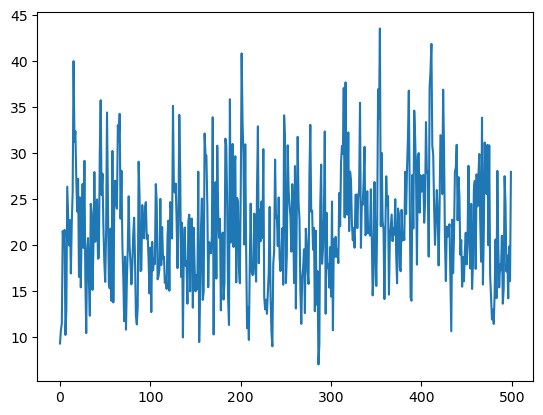

In [22]:
hotelling = HotellingT2().fit(x)
x_t2_scores = hotelling.score_samples(x)
plt.plot(x_t2_scores)

[0, 3, 10, 15, 17, 18, 19]
[0, 3, 6, 10, 12, 15, 17, 18, 19]
[10, 12, 19, 21]


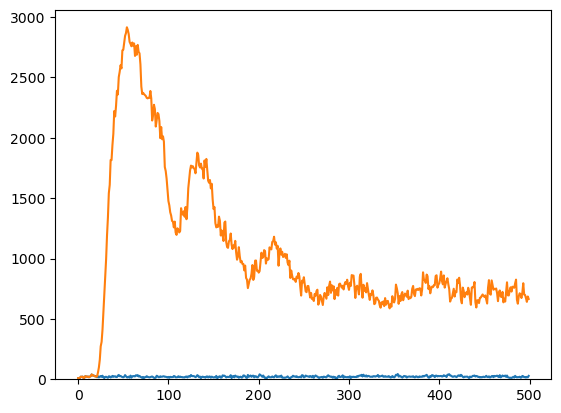

In [125]:
x2 = ss.transform(train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==1)].iloc[:,3:25])

hotelling = HotellingT2().fit(x)
x_t2_scores = hotelling.score_samples(x)
plt.plot(x_t2_scores)

t2_scores = hotelling.score_samples(x2)
plt.plot(t2_scores)

myt_dec = MYTDecomposition(hotelling)
uncond_t2_terms = myt_dec.unconditional_t2_terms(x2)
uncond_ucl = myt_dec.ucl_unconditional_terms()
cond_t2_terms = myt_dec.conditional_t2_terms(x2)
cond_ucl = myt_dec.ucl_conditional_terms()
# condition yields less variables, so use condition for now
variables = MCTvariables(cond_t2_terms, t2_scores)
print(MCTvariables(cond_t2_terms, t2_scores))
print(MCTvariables(uncond_t2_terms, t2_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_st

C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_st

C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:146: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_st

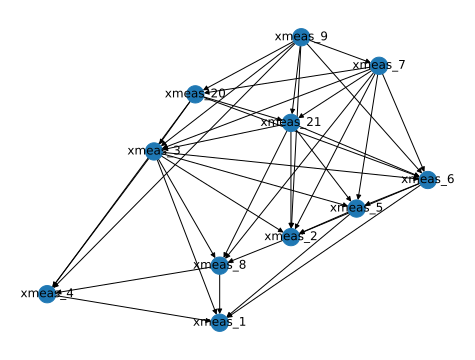

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\a

C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\p

C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\a

C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:226: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1])
C:\Users\paulo\anaconda3\Lib\site-packages\pgmpy\estimators\StructureScore.py:213: RuntimeWarning: overflow encountered in scalar multiply
  counts_size = num_parents_states * len(self.state_names[variable])
C:\Users\paulo\a

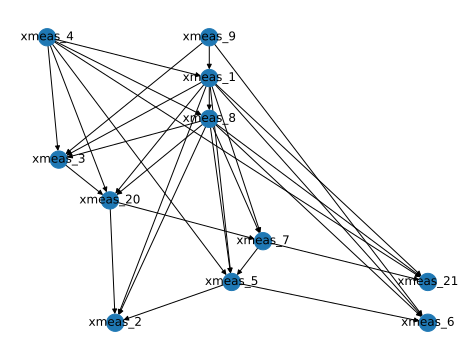

  0%|          | 0/100 [00:00<?, ?it/s]

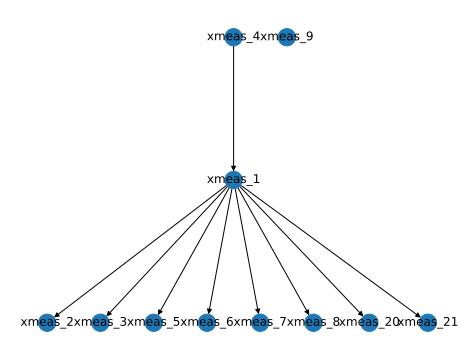

  0%|          | 0/100 [00:00<?, ?it/s]

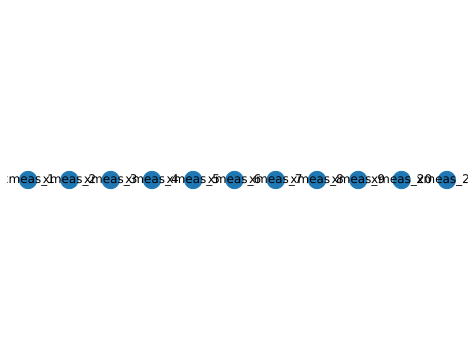

  0%|          | 0/100 [00:00<?, ?it/s]

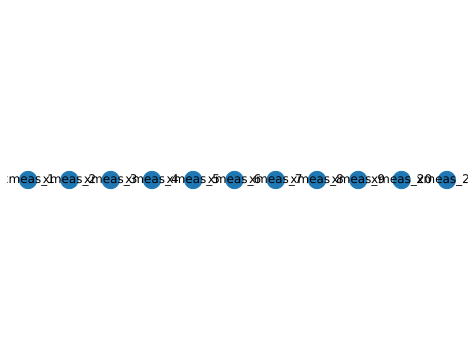

In [80]:
fault = alarm_df(df_train_normal, df_train_faulty).loc[:, reactor]


# learn graph structure
est = HillClimbSearch(df_train_normal.loc[:, reactor])
# k2score, bdeuscore, bdsscore, bicscore, aicscore
for score in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    best_model = est.estimate(max_iter=100, scoring_method=score, max_indegree=None)
    write_dot(best_model,'test.dot')
    pos =graphviz_layout(best_model, prog='dot')
    nx.draw(best_model, pos, with_labels=True, arrows=True)
    plt.show()

In [45]:
"""
# PC estimator, outputs a very low number of variables
from pgmpy.estimators import PC
est = PC(equal_width_bin(df_train_faulty.iloc[:, variables]))
# 0.001 has 2 edges df_train_normal[variables]
model_chi = est.estimate(significance_level=0.01)
print(len(model_chi.edges()))
nx.draw_circular(
    model_chi, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# Funtion to evaluate the learned model structures. Not useful since we don't know the actual structure.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model.to_undirected(), nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model.to_undirected(), nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
est = PC(data=df_train_normal)
estimated_model = est.estimate(variant="stable", max_cond_vars=4)
get_f1_score(estimated_model, model)
"""

'\n# Funtion to evaluate the learned model structures. Not useful since we don\'t know the actual structure.\ndef get_f1_score(estimated_model, true_model):\n    nodes = estimated_model.nodes()\n    est_adj = nx.to_numpy_array(\n        estimated_model.to_undirected(), nodelist=nodes, weight=None\n    )\n    true_adj = nx.to_numpy_array(\n        true_model.to_undirected(), nodelist=nodes, weight=None\n    )\n\n    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))\n    print("F1-score for the model skeleton: ", f1)\nest = PC(data=df_train_normal)\nestimated_model = est.estimate(variant="stable", max_cond_vars=4)\nget_f1_score(estimated_model, model)\n'

algorithm: CAM
time elpased: 2.0196945667266846
algorithm: CCDr
time elpased: 1.1012718677520752
algorithm: GES
time elpased: 0.8000845909118652
algorithm: GIES
time elpased: 0.8049359321594238
algorithm: LiNGAM
time elpased: 0.8503768444061279
algorithm: PC
time elpased: 1.916764736175537


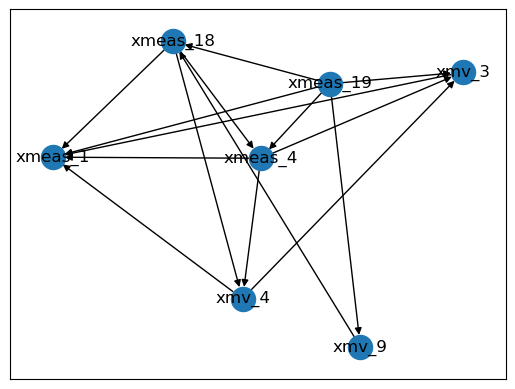

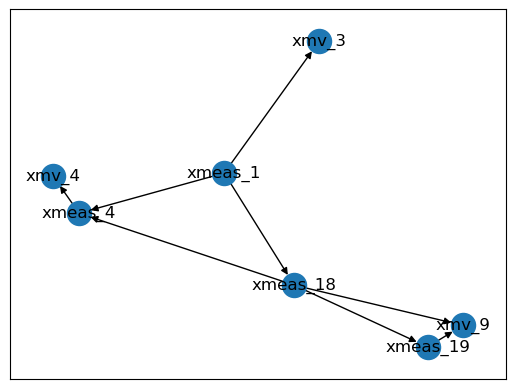

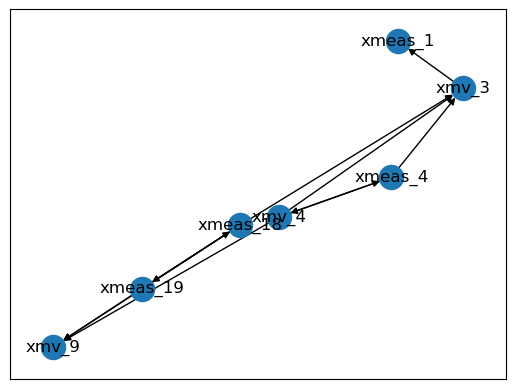

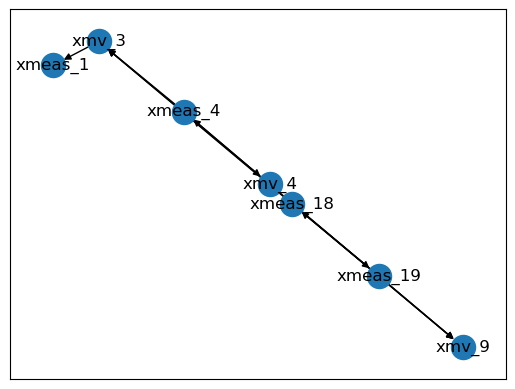

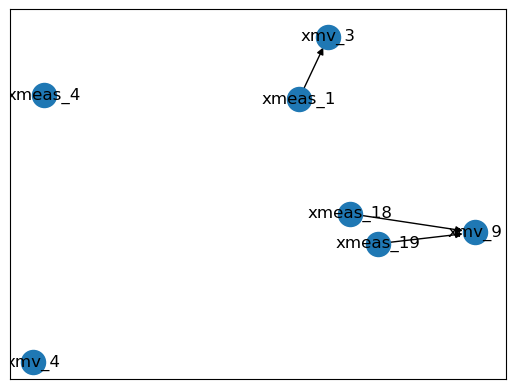

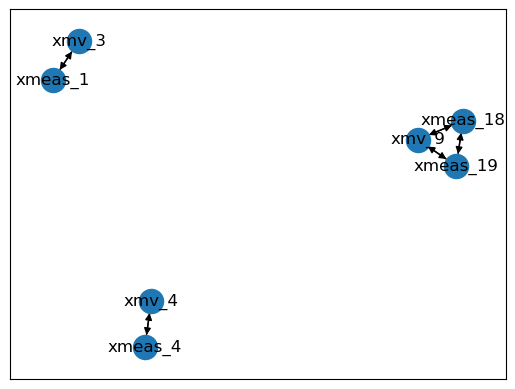

In [18]:
algorithms = [ cdt.causality.graph.CAM() # 2 mins
             , cdt.causality.graph.CCDr()
             , cdt.causality.graph.GES()
             , cdt.causality.graph.GIES()
             , cdt.causality.graph.LiNGAM()
             , cdt.causality.graph.PC()]
nalgo = len(algorithms)
for i in range(nalgo):
    algo = str(algorithms[i]).split(sep='.')[3]
    print("algorithm:", algo)
    start = time.time()
    g = algorithms[i].predict(fault7)
    end = time.time()
    print("time elpased:", end - start)
    plt.figure(algo)
    nx.draw_networkx(g, with_labels=True)
plt.show()

In [52]:
# Analyse distribution of variables, e.g. normally distributed with normality test like Anderson-Darling Test
from scipy.stats import anderson

# Create header for tabular output
print(f"{'DISTRIBUTION':<15}{'%sig':<10}{'stat':<12}{'crit-val':<10}"
      f"{'result':<10}\n")

# Loop through all continuous random variables and test them
for var in df_train_normal.columns:
    test = anderson(df_train_normal[var])
    # Loop through test results and unpack the sig.levels and crit-vals
    for i in range(len(test.critical_values)):
        sig_lev, cv = test.significance_level[i], test.critical_values[i]
        # Check if test.stat is < crit-val
        result = 'Fail to reject' if test.statistic < cv else 'Reject'
        # Print results in tabular format
        print(f"{var:<15}{sig_lev:<10}{test.statistic:<12.3f}{cv:<10}"
              f"{result:<10}")  
        if i is 4:
            print('\n')

DISTRIBUTION   %sig      stat        crit-val  result    

xmeas_1        15.0      0.661       0.571     Reject    
xmeas_1        10.0      0.661       0.651     Reject    
xmeas_1        5.0       0.661       0.781     Fail to reject
xmeas_1        2.5       0.661       0.911     Fail to reject
xmeas_1        1.0       0.661       1.083     Fail to reject


xmeas_2        15.0      0.634       0.571     Reject    
xmeas_2        10.0      0.634       0.651     Fail to reject
xmeas_2        5.0       0.634       0.781     Fail to reject
xmeas_2        2.5       0.634       0.911     Fail to reject
xmeas_2        1.0       0.634       1.083     Fail to reject


xmeas_3        15.0      0.828       0.571     Reject    
xmeas_3        10.0      0.828       0.651     Reject    
xmeas_3        5.0       0.828       0.781     Reject    
xmeas_3        2.5       0.828       0.911     Fail to reject
xmeas_3        1.0       0.828       1.083     Fail to reject


xmeas_4        15.0      0.33

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\paulo\AppData\Local\Temp\ipykernel_6696\859025840.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 4:
